In [1]:
from keras_segmentation.models import unet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import re
import glob
from utils_segmentation import bb_intersection_over_union, build_hist, augmentation_images, create_annotations
import numpy as np

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data_fortnite_3_classes.csv')

In [3]:
n_cl = data.labels.unique().shape[0]

In [30]:
data.head()

bbox_x1  bbox_y1  bbox_x2  bbox_y2  bbox_x3  bbox_y3  bbox_x4  bbox_y4  \
0      769      474     1146      471     1145      509      771      511   
1     1546      353     1779      354     1779      384     1546      387   
2     1572      310     1775      310     1777      338     1572      344   
3      765      143     1311       98     1189      295      612      330   
4     1630       61     1814       63     1815       91     1628       96   

   labels             fname  img_type  
0       1  0GD3EH8SIE_1.jpg         2  
1       2  0GD3EH8SIE_1.jpg         2  
2       2  0L1EIKM8SU_0.jpg         2  
3       3  8A9B87F189_1.jpg         5  
4       2  8A9B87F189_1.jpg         5

In [31]:
data[data.labels==1]

bbox_x1  bbox_y1  bbox_x2  bbox_y2  bbox_x3  bbox_y3  bbox_x4  bbox_y4  \
0       769      474     1146      471     1145      509      771      511   
5       769      476     1147      472     1146      509      769      511   
7       780      475     1141      470     1141      508      778      511   
11      681     1765     1873     1705     1869     1845      689     1885   
13      775      469     1145      469     1145      511      775      511   
21     1273     1429     2241     1421     2237     1541     1273     1533   
23     1225     1293     1825     1269     1833     1361     1233     1369   
25      771      527     1147      515     1147      571      769      575   
27      771      469     1143      465     1145      513      769      513   

    labels             fname  img_type  
0        1  0GD3EH8SIE_1.jpg         2  
5        1  4BF14869E1_0.jpg         2  
7        1  3AB6FC95D6_0.jpg         2  
11       1  146073D685_0.jpg         2  
13       1  ACDD33A017_0.jpg         2  
21       1  4Z8ZB18LX0_1.jpg         2  
23       1  5GCCFRJIUU_1.jpg         2  
25       1  E708CACBAC_1.jpg         2  
27       1  N3WKQYXZDE_1.jpg         2

## Model

In [4]:
model = unet.mobilenet_unet(n_classes=n_cl+1, input_height=224, input_width=224,)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
model.load_weights('fortnite_3_classes.h5')

## Test of Model

## Test IOU

In [ ]:
# 3 classes {'team place': 1, 'match_stat': 2, 'victory_royale': 3}

In [6]:
test_data = pd.read_csv('test_data_fortnite_3_classes.csv')

In [7]:
test_data.head()

bbox_x1  bbox_y1  bbox_x2  bbox_y2  bbox_x3  bbox_y3  bbox_x4  bbox_y4  \
0      482       51      870       17      792      147      401      167   
1     1056        1     1215        1     1215       18     1056       22   
2      713      661     2033      553     1745     1005      437     1085   
3     2681      493     3261      481     3253      577     2681      577   
4      735      149     1307       97     1189      291      601      337   

   labels             fname  img_type  
0       3  HN7ZE8WQ7K_1.jpg         5  
1       2  HN7ZE8WQ7K_1.jpg         5  
2       3  LRDRCXLBOK_0.jpg         5  
3       2  LRDRCXLBOK_0.jpg         5  
4       3  M7YRPKB7RE_1.jpg         5

In [8]:
#number of classes on image
n_classes = 2

In [9]:
img_folder = 'data_3_classes/test_imgs/'
annotation_folder = 'data_3_classes/test_annotations/'
#create_annotations(test_data,img_folder, annotation_folder)

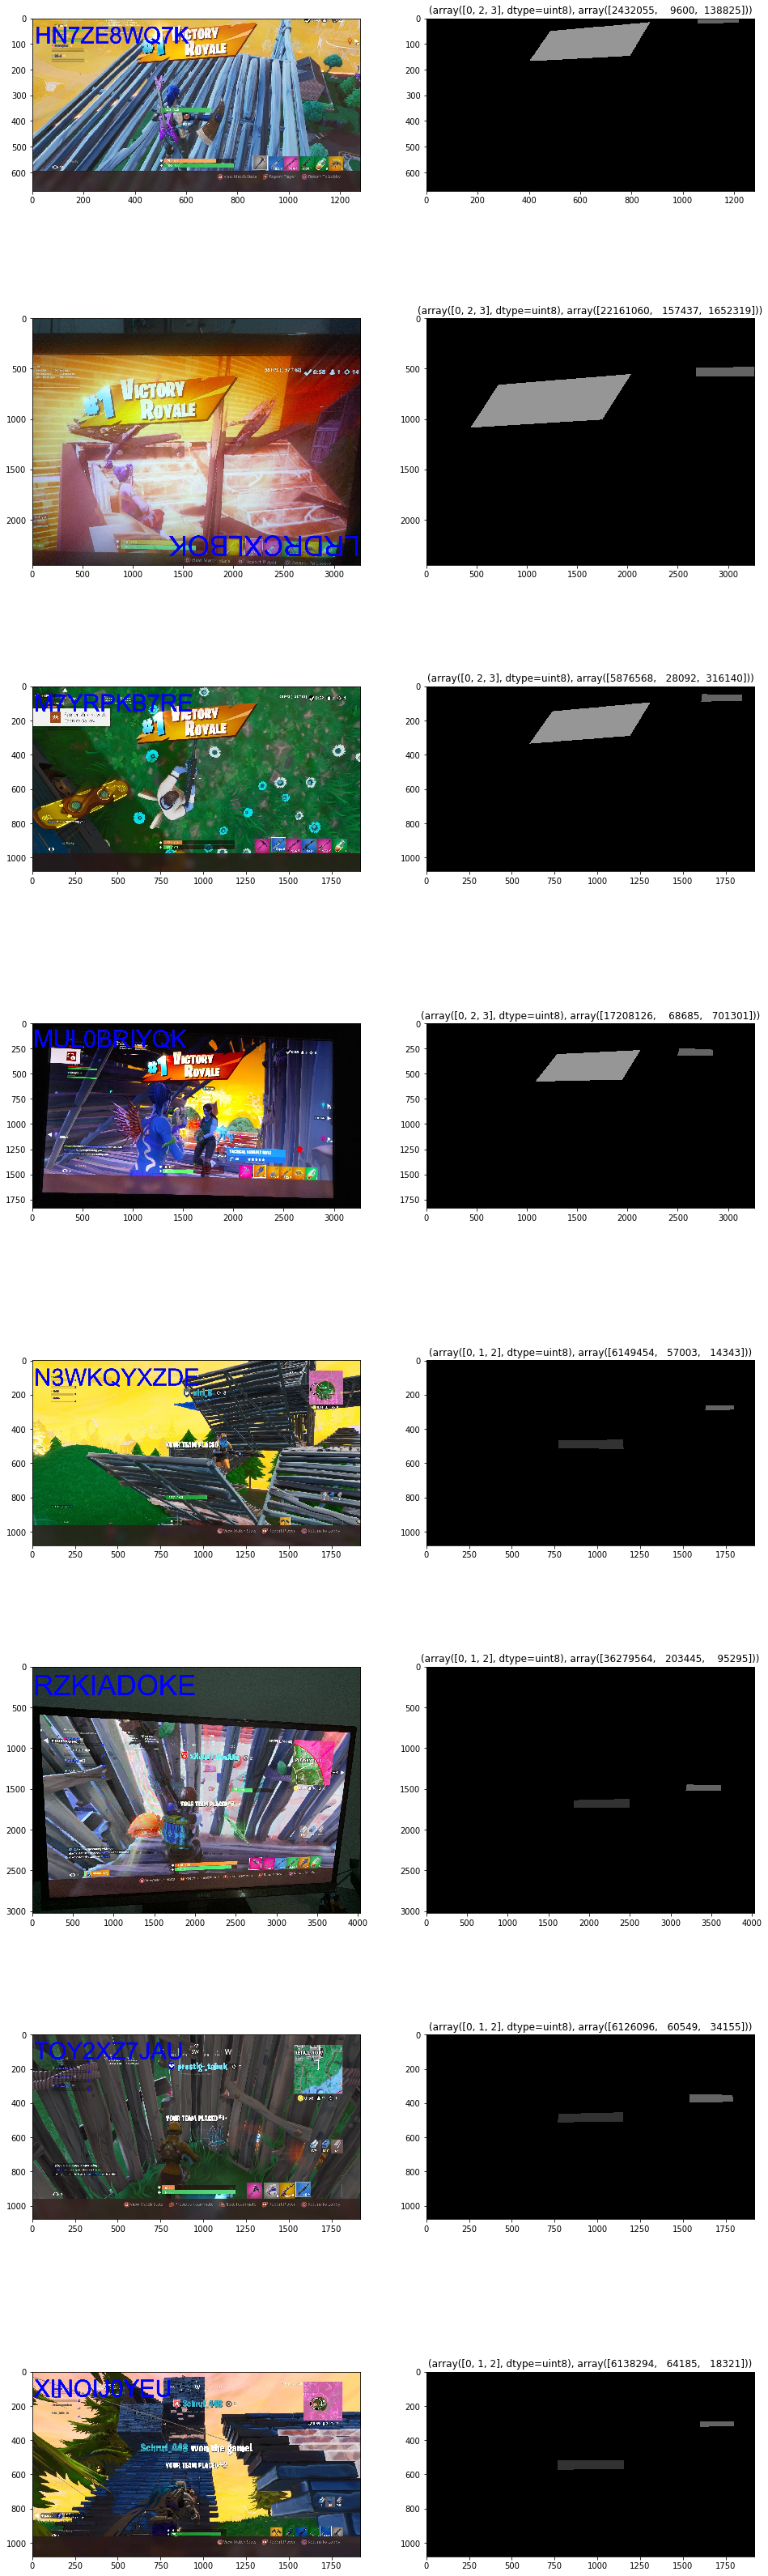

In [10]:
test_files = glob.glob('data_3_classes/test_imgs/*.jpg')
row = len(test_files)
i=1

plt.figure(figsize=(16,60))
for f in test_data.fname.unique():
    img = cv2.imread('data_3_classes/test_imgs/'+f)
    msk = cv2.imread('data_3_classes/test_annotations/'+f.split('.')[0]+'.png')
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(img)
    plt.subplot(row,2,i)
    plt.title(np.unique(msk,return_counts=True))
    i+=1
    plt.imshow(msk*50)

In [124]:
def detect_classes_v(img,n_classes):
    """
    Detect classes that are most represemted on mask
    """
    labels, counts = np.unique(img, return_counts=True)
    labels = labels[1:]
    counts = counts[1:]

    inds = np.argsort(counts)
    list_classes = [labels[inds[-i]] for i in range(1, len(labels) + 1)]
        
    return list_classes

def find_segments_v(mask_img,cls):
    """
    Find segments on mask
    Inputs:
    mask_img - segmentation mask image from model
    cls - labels of classes that are on image
    Outputs:
    segments - segmnets that were found

    """
    thresh_1 = 1
    segments={}
    for cl in cls:
        
        cols = np.sum(mask_img==cl,axis=1)
        rows = np.sum(mask_img==cl,axis=0)
        col_cond1= (cols>=np.mean(cols[cols>thresh_1])/1.5)
        row_cond1= (rows>=np.mean(rows[rows>thresh_1])/1.5)
        
        col_indecies = np.where(col_cond1)[0]
        row_indecies = np.where(row_cond1)[0]
        
        koef_x_r = 0
        koef_x_l = 0
        koef_y = 0
        
        if cl==1:
            koef_x_r = 4
            koef_x_l = 3
            koef_y = 2
        elif cl == 2:
            koef_x_r = 6
            koef_x_l = 2
            koef_y = 1
        elif cl == 3:
            koef_x_r = 2
            koef_x_l = 5
            koef_y = 3
            

        x1 = row_indecies[0]-koef_x_l if (row_indecies[0]-koef_x_l)>0 else 0
        y1 = col_indecies[0]-koef_y if (col_indecies[0]-koef_y)>0 else 0
        x2 = row_indecies[-1]+koef_x_r if (row_indecies[-1]+koef_x_r)<mask_img.shape[1] else mask_img.shape[1]
        y2 = col_indecies[-1]+koef_y if (col_indecies[-1]+koef_y)<mask_img.shape[1] else mask_img.shape[1]
        
        segments[cl] = [(x1,y1),(x2,y2)]
    return segments

def crop_rect_v(im, rect, scaler={'h': 1, 'w': 1}):
    """
    Crop original image by segments.
    Input:
    im - raw image
    rect - rectangle for cropping
    scaler - scaler for rectangle
    Return:
    crop_img - crop segment with original resolution
    coordinates - coordinates of crop rectangle
    """
#     k_w=5
#     k_h=6
    
    h1 = int(rect[0][1]*scaler['h'])
    w1 = int(rect[0][0]*scaler['w'])
    h2 = int(rect[1][1]*scaler['h'])
    w2 = int(rect[1][0]*scaler['w'])
    
#     h1_ = h1-k_h if (h1-k_h)>0 else 0
#     w1_ = w1-k_w if (w1-k_w)>0 else 0
#     h2_ = h2+k_h if (h2+k_h)<im.shape[1] else im.shape[1]
#     w2_ = w2+k_w if (w2+k_w)<im.shape[1] else im.shape[1]
    
    crop_img = im[h1:h2, w1:w2]
    #[(x1,y1),(x2,y2)]
    coordinates = [(w1,h1),(w2,h2)]
    print(f'coordinates: {coordinates}')
    return crop_img, coordinates

In [106]:
def IOU_list_files_v(test_data,model,img_folder='data_3_classes/test_imgs/',
                   annotation_folder = 'data_3_classes/test_annotations/',
                  size=(224,224)):

    """
    For testing accuracy of model. I use metric IOU.
    Input:
    test_data - data frame with columns:  'fname','labels','bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4'
    img_folder - folder with test images

    """
    m=np.array([[True,True],[False,False],[True,True],[False,False]])
    
    predicted_boxes = {}
    real_boxes = {}
    IOUs = {}
    k=1
    plt.figure(figsize=(15,60))
    for f in test_data.fname.unique():
        n_classes = 2

        img = cv2.imread(img_folder+f)
        img_r = cv2.resize(img, size)

        out = model.predict_segmentation(img_r)
        
        plt.subplot(8,2,k)
        plt.title(np.unique(out,return_counts=True))
        plt.imshow(out)
        k+=1
       #cv2.imshow(f'{f}',out*50)
        h_scale = img.shape[0] / out.shape[0]
        w_scale = img.shape[1] / out.shape[1]
        scaler = {'h': h_scale, 'w': w_scale, }
        list_cls = detect_classes_v(out,n_classes)
        
        rects = find_segments_v(out,list_cls)
        img_r_2 = cv2.resize(img_r, (112,112))
        for r in rects:
            cv2.rectangle(img_r_2,*rects[r],(255,255,0),2)
        
        plt.subplot(8,2,k)
        plt.title(r)
        plt.imshow(img_r_2)
        k+=1

        segments = {}
        for r in rects:
            crop_img, coordinates = crop_rect_v(img, rects[r], scaler=scaler)
            segments[r]={'data': crop_img, 'coordinates':coordinates}

        predicted_boxes[f] = segments

        real_boxes[f]={}
        IOUs[f] = {}

        for l in test_data[test_data.fname==f].labels:
            pts=test_data[(test_data.fname==f)&(test_data.labels==l)][['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'bbox_x3', 'bbox_y3',
       'bbox_x4', 'bbox_y4']].values[0].astype('int').reshape(4,2)
            real_boxes[f][l] = pts[m]
            
            
            if segments.get(l,0):
                
                boxA= np.ravel(segments[l]['coordinates'])
                boxB = pts[m]

                IOUs[f][l] = bb_intersection_over_union(boxA, boxB)
            else:
                IOUs[f][l] = 0
            
    return IOUs

coordinates: [(422, 30), (845, 168)]
coordinates: [(1051, 0), (1211, 18)]
coordinates: [(553, 590), (1894, 1071)]
coordinates: [(2360, 480), (3264, 568)]
coordinates: [(617, 106), (1251, 327)]
coordinates: [(1577, 48), (1868, 86)]
coordinates: [(1078, 262), (2040, 590)]
coordinates: [(2622, 262), (3001, 327)]
coordinates: [(737, 453), (1200, 530)]
coordinates: [(1594, 250), (1868, 289)]
coordinates: [(1525, 347), (1851, 395)]
coordinates: [(840, 462), (1148, 520)]
coordinates: [(754, 520), (1320, 578)]
coordinates: [(1045, 289), (1834, 559)]


{'HN7ZE8WQ7K_1.jpg': {3: 0.5118603230623049, 2: 0.8968380709038646},
 'LRDRCXLBOK_0.jpg': {3: 0.5509597368144405, 2: 0.5081328323726401},
 'M7YRPKB7RE_1.jpg': {3: 0.4615521032843867, 2: 0.7265954805065806},
 'MUL0BRIYQK_0.jpg': {3: 0.5182544416984664, 2: 0.4089806863891821},
 'N3WKQYXZDE_2.jpg': {1: 0.5158322281167109, 2: 0.4000909090909091},
 'RZKIADOKE_1.jpg': {1: 0, 2: 0},
 'TOY2XZ7JAU_2.jpg': {1: 0.6748292365596394, 2: 0.6945945945945946},
 'XINOIJ0YEU_0.jpg': {1: 0.5977188109449796, 2: 0.026685039002288757}}

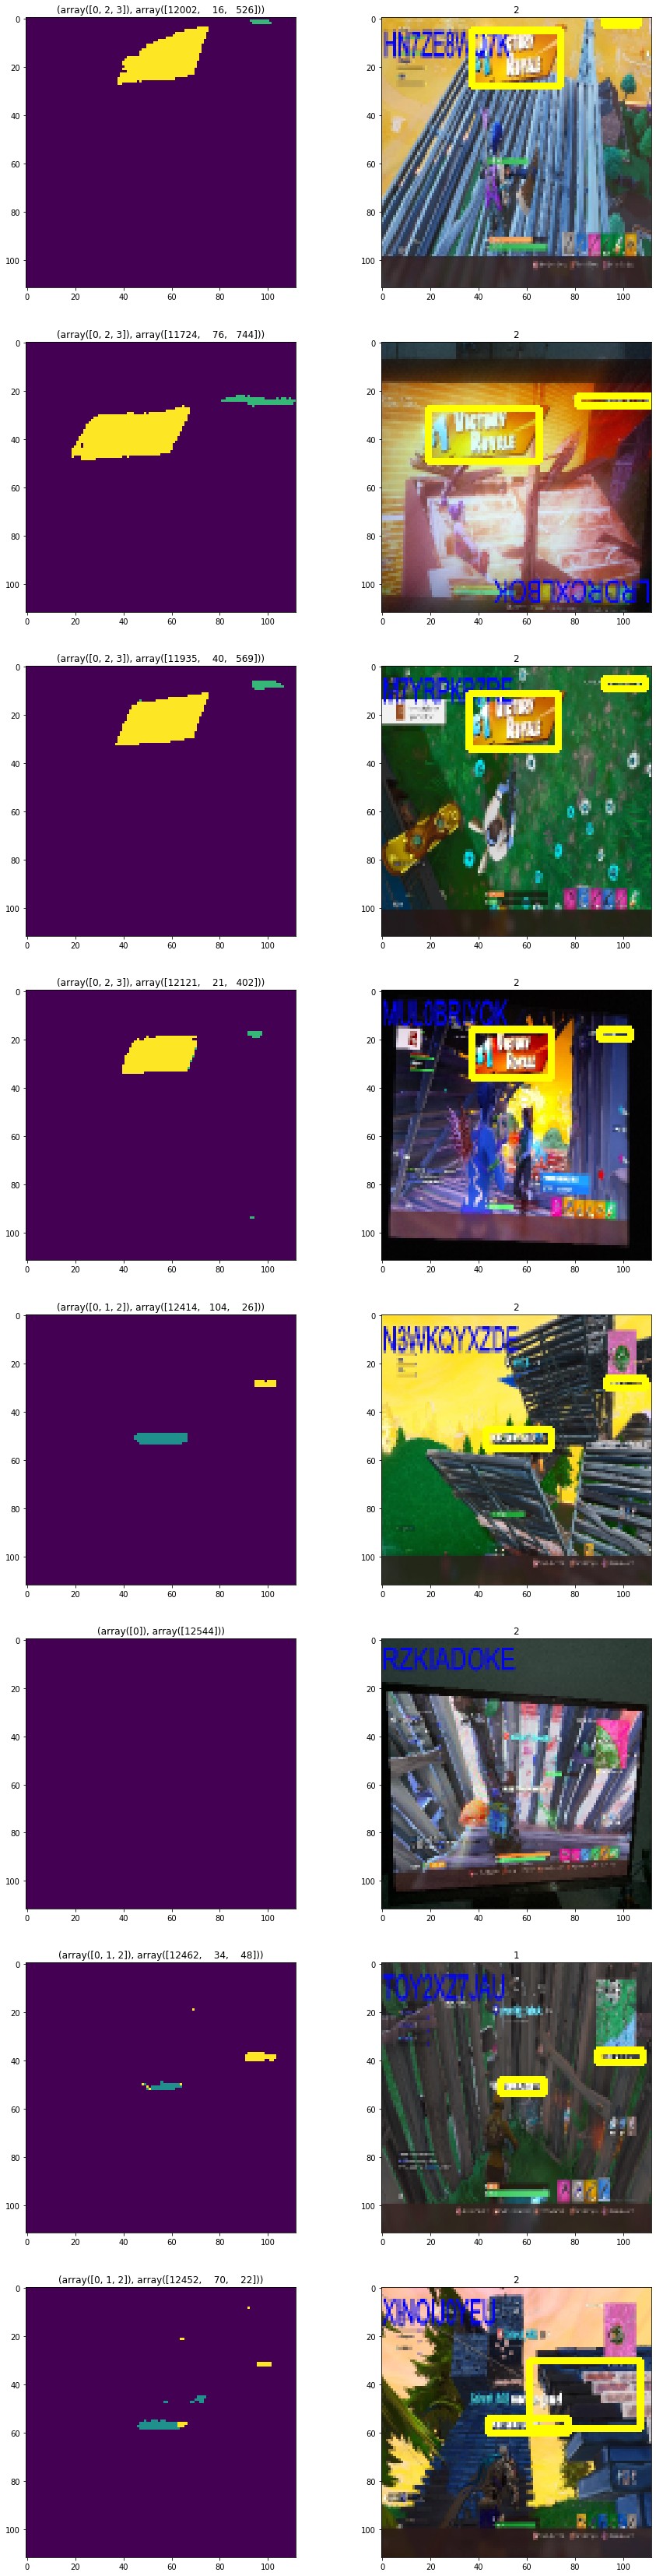

In [125]:
IOUs = IOU_list_files_v(test_data,model,img_folder='data_3_classes/test_imgs/',
                   annotation_folder = 'data_3_classes/test_annotations/',
                  size=(224,224))
IOUs

In [126]:
ACC = pd.DataFrame.from_dict(IOUs, orient='index')
ACC.mean()

3    0.510657
2    0.457740
1    0.447095
dtype: float64

In [109]:
ACC = pd.DataFrame.from_dict(IOUs, orient='index')
ACC.mean()

3    0.510657
2    0.457740
1    0.449385
dtype: float64

In [155]:
# Visualize results for each image

In [36]:
def analysis_v(f, model, path='data_3_classes/test_imgs/', size=(224,224), test_data=test_data):
    """
    Visualization of work of model
    """
    n_classes = 2
    img = cv2.imread(path+f)
    img_r = cv2.resize(img, size)
    img_r_mask = cv2.resize(img, (int(size[0]/2),int(size[1]/2)))

    out = model.predict_segmentation(img_r)
    
    if len(np.unique(out))>1:

        h_scale = img.shape[0] / out.shape[0]
        w_scale = img.shape[1] / out.shape[1]
        scaler = {'h': h_scale, 'w': w_scale, }

        list_cls = detect_classes_v(out,n_classes)
        rects = find_segments_v(out,list_cls)
        segments = []
        for r in rects:
            crop_img, coordinates = crop_rect_v(img, rects[r], scaler=scaler)
            segments.append({'label': r, 'data': crop_img, 'coordinates':coordinates})

            cv2.rectangle(img_r_mask,*rects[r],(255,255,0),2)

        print(f'Find segments: {len(segments)}')
        plt.figure(figsize=(8,8))
        plt.subplot(2,2,1)
        plt.title(f"Label: {segments[0]['label']}")
        plt.imshow(segments[0]['data'])
        plt.subplot(2,2,2)
        if  len(segments)>1:
            plt.title(f"Label: {segments[1]['label']}")
            if segments[1]['data'].any():
                plt.imshow(segments[1]['data'])
        else:
            plt.title(f"Label: None")

        plt.subplot(2,2,3)
        plt.title(f"mask")
        plt.imshow(out)
        plt.subplot(2,2,4)
        plt.title(f"image")
        plt.imshow(img_r_mask)
    else:
        print('No class detection')
    return out

In [37]:
#test_data

coordinates: [(422, 30), (845, 168)]
coordinates: [(1051, 0), (1211, 18)]
Find segments: 2


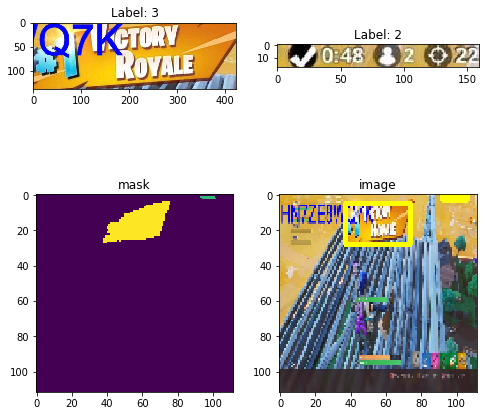

In [110]:
fname='HN7ZE8WQ7K_1.jpg'
msk = analysis_v(f=fname, model=model)

In [111]:
#build_hist(msk,[2,3])

coordinates: [(553, 590), (1894, 1071)]
coordinates: [(2360, 480), (3264, 568)]
Find segments: 2


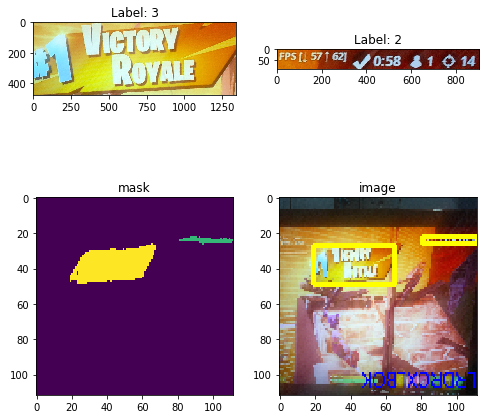

In [112]:
fname='LRDRCXLBOK_0.jpg'
msk = analysis_v(f=fname, model=model)

coordinates: [(617, 106), (1251, 327)]
coordinates: [(1577, 48), (1868, 86)]
Find segments: 2


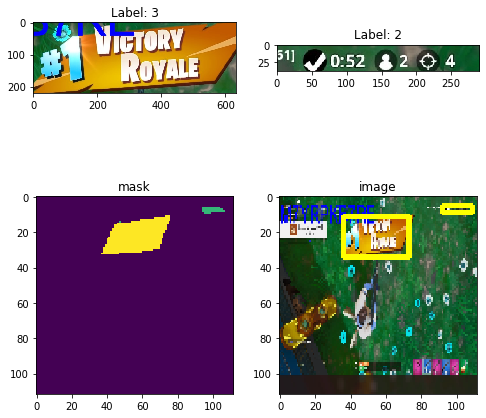

In [113]:
fname = 'M7YRPKB7RE_1.jpg'
msk = analysis_v(f=fname, model=model)

coordinates: [(1078, 262), (2040, 590)]
coordinates: [(2622, 262), (3001, 327)]
Find segments: 2


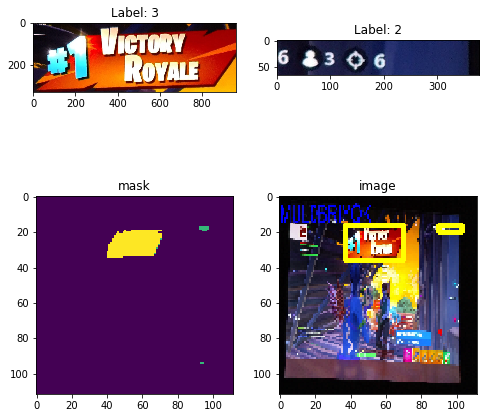

In [114]:
fname = 'MUL0BRIYQK_0.jpg'
msk = analysis_v(f=fname, model=model)

coordinates: [(737, 453), (1182, 530)]
coordinates: [(1594, 250), (1868, 289)]
Find segments: 2


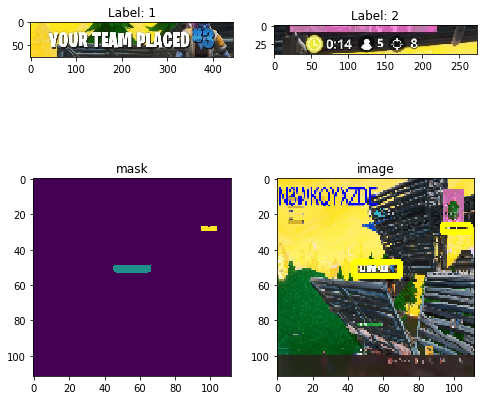

In [115]:
fname='N3WKQYXZDE_2.jpg'
msk = analysis_v(f=fname, model=model)

In [99]:
#build_hist(msk,[1,2])

In [21]:
fname='RZKIADOKE_1.jpg'
msk = analysis_v(f=fname, model=model)

No class detection


coordinates: [(1525, 347), (1851, 395)]
coordinates: [(840, 462), (1148, 520)]
Find segments: 2


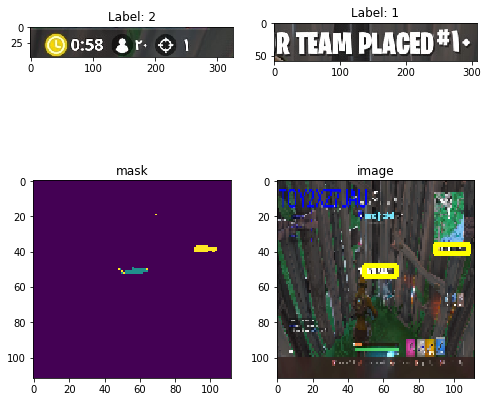

In [127]:
fname='TOY2XZ7JAU_2.jpg'
msk = analysis_v(f=fname, model=model)

In [104]:
#build_hist(msk,[2,3])

coordinates: [(754, 520), (1302, 578)]
coordinates: [(1045, 289), (1834, 559)]
Find segments: 2


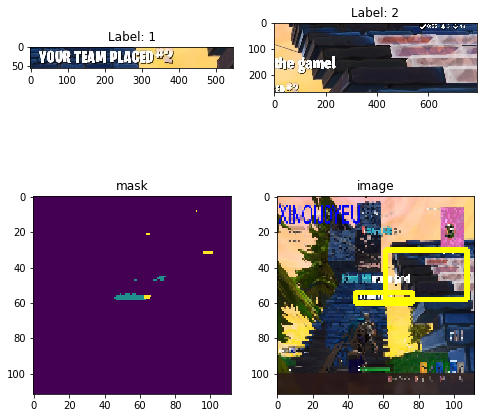

In [117]:
fname='XINOIJ0YEU_0.jpg'
msk = analysis_v(f=fname, model=model)

In [25]:
#TBD
# detect shape of rectangle for classes: 1 and 3. Increase to expected shape
# add to train dayaset image with fail detection, change to good sample
# good idea was to increase dataset to 10 images pear class

## System test

In [26]:
system_test_data = pd.read_csv('data_3_classes/data_fortnite_3_classes_system_test.csv')
system_test_data.head()

fname                         text
0  0GD3EH8SIE_1.jpg    {'place': 17, 'kills': 1}
1  0L1EIKM8SU_0.jpg  {'place': None, 'kills': 5}
2  3AB6FC95D6_0.jpg     {'place': 4, 'kills': 5}
3  4BF14869E1_0.jpg    {'place': 13, 'kills': 1}
4  8A9B87F189_1.jpg     {'place': 1, 'kills': 8}

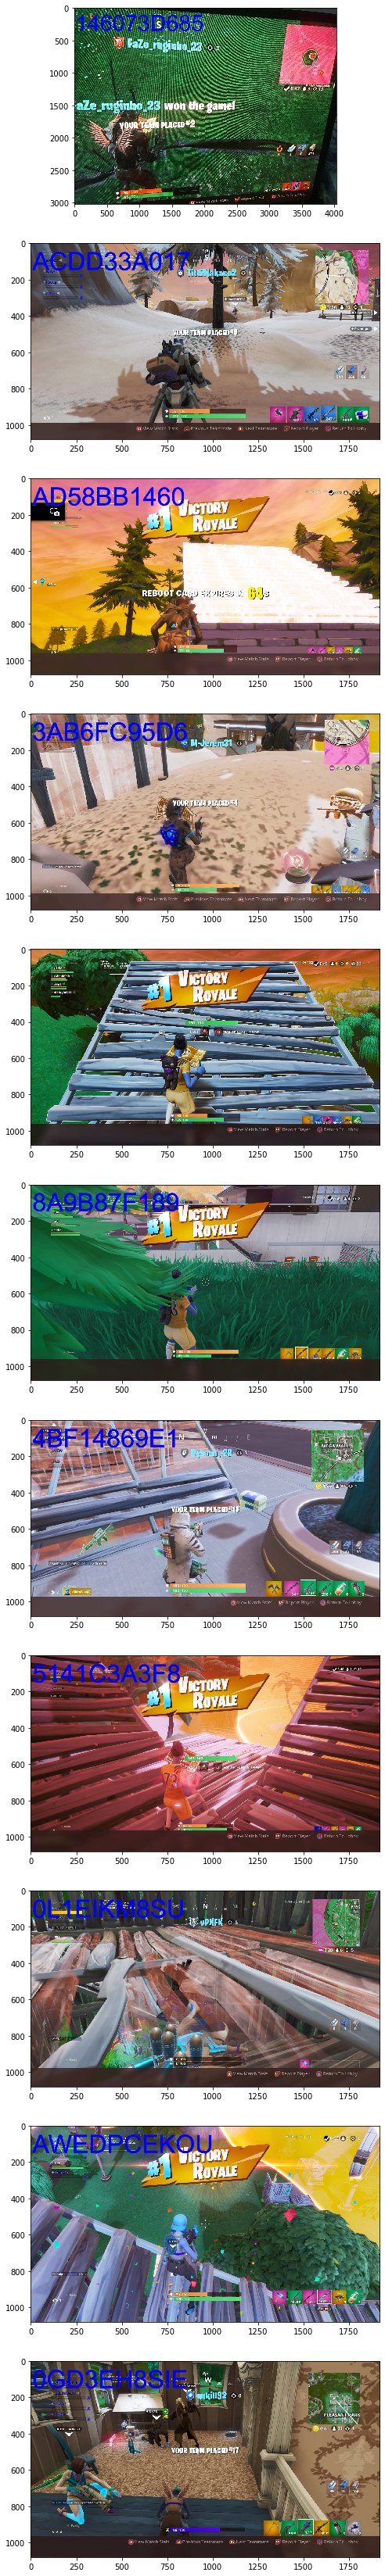

In [13]:
system_test_files = glob.glob('data_3_classes/system_tes_imgs/*.jpg')
row = len(system_test_files)
i=1

plt.figure(figsize=(16,60))
for f in system_test_files:
    img = cv2.imread(f)
#     msk = cv2.imread('data_3_classes/test_annotations/'+f.split('.')[0]+'.png')
    plt.subplot(row,1,i)
    i+=1
    plt.imshow(img)

coordinates: [(612, 1701), (1908, 1890)]
coordinates: [(3132, 1161), (4032, 1296)]
Find segments: 2


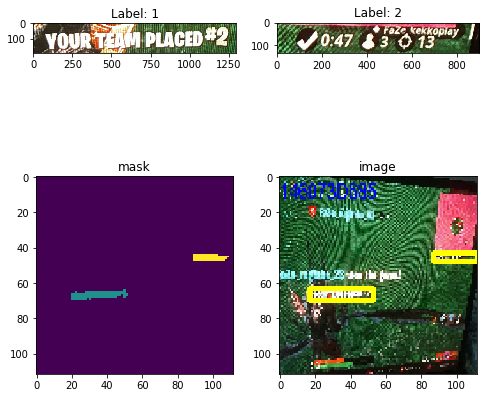

In [118]:
f = '146073D685_0.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

coordinates: [(737, 453), (1182, 520)]
coordinates: [(1542, 327), (1920, 376)]
Find segments: 2


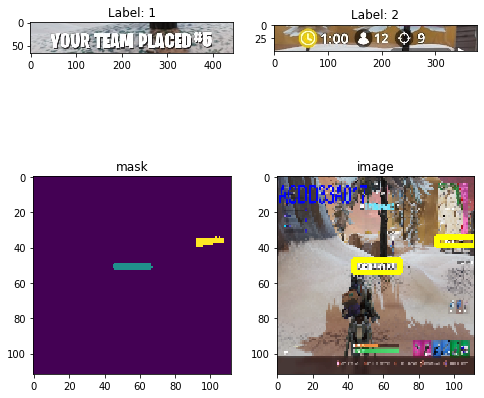

In [119]:
f = 'ACDD33A017_0.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

coordinates: [(600, 106), (1268, 327)]
coordinates: [(1594, 57), (1902, 96)]
Find segments: 2


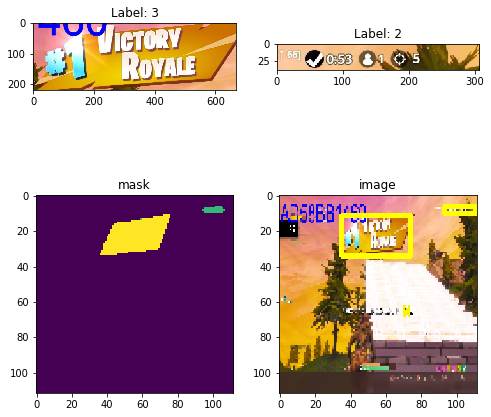

In [120]:
f = 'AD58BB1460_1.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

coordinates: [(737, 453), (1182, 520)]
coordinates: [(1594, 279), (1920, 318)]
Find segments: 2


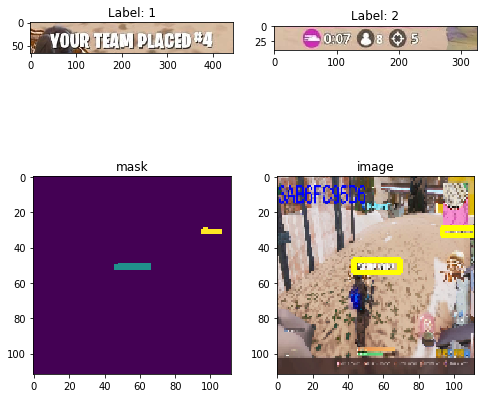

In [121]:
f = '3AB6FC95D6_0.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

coordinates: [(617, 106), (1268, 327)]
coordinates: [(1525, 57), (1902, 96)]
Find segments: 2


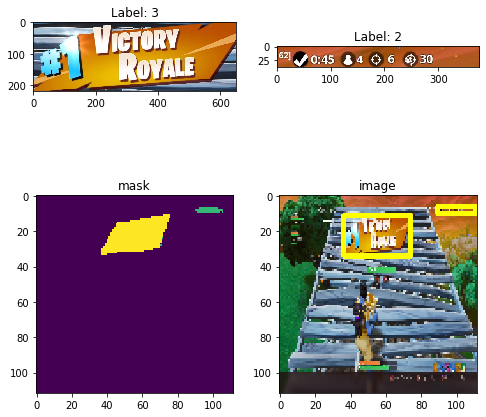

In [122]:
f = 'KJPCNUM8J0_1.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)

coordinates: [(617, 106), (1251, 337)]
coordinates: [(1611, 57), (1902, 96)]
Find segments: 2


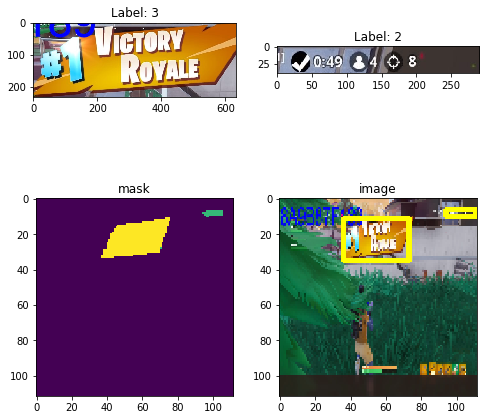

In [123]:
f = '8A9B87F189_1.jpg'
msk = analysis_v(f, model, path='data_3_classes/system_tes_imgs/', size=(224,224), test_data=system_test_data)